<a href="https://colab.research.google.com/github/budoorhza/PROJECT363/blob/main/2106601_2105535_SegmentationClassificationBrainMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Mada Ghurab 2105535
Budoor Alarfaj 2106601

In [1]:
import os
import zipfile
import glob
import json
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset_zip_path = '/content/drive/MyDrive/363PROJECT/BTID.zip'
extracted_folder_path = '/content/BTID/'

In [4]:
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Dataset paths
train_path = os.path.join(extracted_folder_path, 'train/')
test_path = os.path.join(extracted_folder_path, 'test/')
valid_path = os.path.join(extracted_folder_path, 'valid/')

In [5]:
train_annotation = json.load(open('/content/BTID/train/_annotations.coco.json'))
test_annotation = json.load(open('/content/BTID/test/_annotations.coco.json'))
valid_annotation = json.load(open('/content/BTID/valid/_annotations.coco.json'))

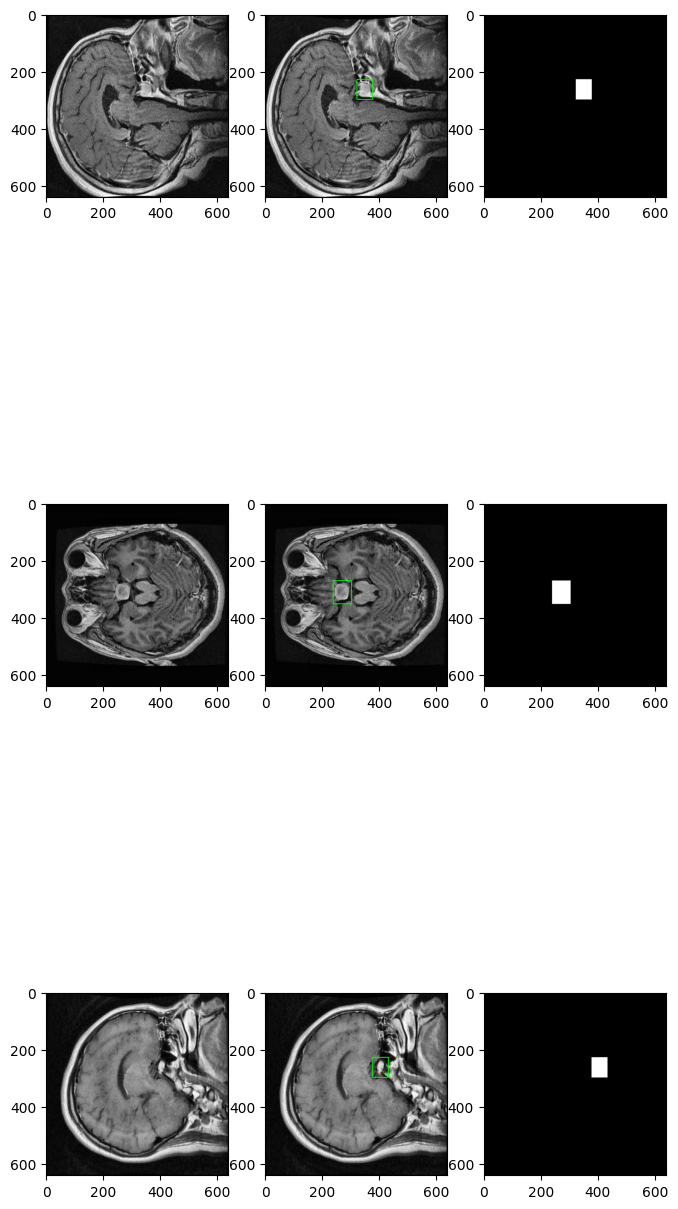

In [6]:
def visualize_random_images(n=3):  # select n random images
    indices = np.random.randint(0, len(train_annotation['images']), size=n)
    images = [train_annotation['images'][i] for i in indices]
    annotations = [train_annotation['annotations'][i] for i in indices]

    j = 1
    plt.figure(figsize=(8, 3 * 2 * n))
    for img, ann in zip(images, annotations):
        plt.subplot(n, 3, j)
        j += 1
        image = cv2.imread(os.path.join(train_path, img['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)

        # create masked images from annotations
        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
        cv2.polylines(image, [segmentation], isClosed=True, color=(0, 255, 0), thickness=2)  # Green color with thickness 2

        plt.subplot(n, 3, j)
        plt.imshow(image)
        j += 1

        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=1)
        plt.subplot(n, 3, j)
        plt.imshow(mask, cmap='gray')
        j += 1

visualize_random_images()

In [7]:
def create_masks():
    def _create_masks_for_set(annotations, images_path, mask_dir):
        os.makedirs(mask_dir, exist_ok=True)
        total_images = len(annotations['images'])
        for img, ann in zip(annotations['images'], annotations['annotations']):
            path = os.path.join(images_path, img['file_name'])
            mask_path = os.path.join(mask_dir, img['file_name'])
            image = cv2.imread(path)
            segmentation = ann['segmentation']
            segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
            cv2.fillPoly(mask, [segmentation], color=(255, 255, 255))
            cv2.imwrite(mask_path, mask)
            print(f"Processed {mask_path}")

    _create_masks_for_set(train_annotation, train_path, '/content/train_masks/')
    _create_masks_for_set(test_annotation, test_path, '/content/test_masks/')
    _create_masks_for_set(valid_annotation, valid_path, '/content/valid_masks/')

create_masks()

Processed /content/train_masks/2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg
Processed /content/train_masks/2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg
Processed /content/train_masks/2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg
Processed /content/train_masks/2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg
Processed /content/train_masks/2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg
Processed /content/train_masks/2161_jpg.rf.3be4125d1ffe011c0ed462d9fe0d2152.jpg
Processed /content/train_masks/2265_jpg.rf.3c62c7b8825039fab853256f9a9fe141.jpg
Processed /content/train_masks/1491_jpg.rf.3c658e83538de0fa5a3f4e13d7d85f12.jpg
Processed /content/train_masks/1385_jpg.rf.3c67cb92e2922dba0e6dba86f69df40b.jpg
Processed /content/train_masks/2534_jpg.rf.3c8c86666860368d46b8f7bcd95ac220.jpg
Processed /content/train_masks/2433_jpg.rf.3cdf8e4cb3a08e9b2fccc6c6082c2344.jpg
Processed /content/train_masks/1550_jpg.rf.3d067be9580ec32dbee5a89c675d8459.jpg
Processed /content/train_masks/2076_jpg.

In [8]:
def load_data():
    target_size = (128, 128)
    train_mask_dir = '/content/train_masks/'

    X_train = [cv2.resize(cv2.imread(os.path.join(train_path, image['file_name'])), target_size) for image in train_annotation['images']]
    y_train = [cv2.resize(cv2.imread(os.path.join(train_mask_dir, image['file_name']), cv2.IMREAD_GRAYSCALE), target_size) for image in train_annotation['images']]
    X_train = np.array(X_train)
    y_train = np.expand_dims(np.array(y_train), axis=-1)

    X_train = X_train.astype('float32') / 255.0
    y_train = y_train.astype('float32') / 255.0
    y_train = (y_train > 0.5).astype(np.float32)

    val_mask_dir = '/content/valid_masks/'
    X_val = [cv2.resize(cv2.imread(os.path.join(valid_path, image['file_name'])), target_size) for image in valid_annotation['images']]
    y_val = [cv2.resize(cv2.imread(os.path.join(val_mask_dir, image['file_name']), cv2.IMREAD_GRAYSCALE), target_size) for image in valid_annotation['images']]
    X_val = np.array(X_val)
    y_val = np.expand_dims(np.array(y_val), axis=-1)

    X_val = X_val.astype('float32') / 255.0
    y_val = y_val.astype('float32') / 255.0
    y_val = (y_val > 0.5).astype(np.float32)

    return X_train, y_train, X_val, y_val

X_train, y_train, X_val, y_val = load_data()

In [9]:
def downsample_block(input_tensor, filters):
    # إنشاء طبقة Convolution تليها BatchNormalization و ReLU
    f = layers.Conv2D(filters, (3, 3), padding="same")(input_tensor)
    f = layers.BatchNormalization()(f)
    f = layers.ReLU()(f)

    # إنشاء طبقة MaxPooling لتقليص الأبعاد
    p = layers.MaxPooling2D((2, 2))(f)

    return f, p

def upsample_block(input_tensor, concat_tensor, filters):
    # طبقة Conv2D تليها BatchNormalization و ReLU
    u = layers.Conv2D(filters, (3, 3), padding="same")(input_tensor)
    u = layers.BatchNormalization()(u)
    u = layers.ReLU()(u)

    # طبقة Upsampling لزيادة الأبعاد
    u = layers.UpSampling2D((2, 2))(u)

    # دمجها مع الميزة القادمة من مرحلة التناقص (Skip connection)
    u = layers.concatenate([u, concat_tensor], axis=-1)

    return u

In [10]:
def build_unet_model():
    inputs = layers.Input(shape=(128, 128, 3))

    # Encoder
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # Bottleneck
    bottleneck = layers.Conv2D(1024, (3, 3), padding="same")(p4)
    bottleneck = layers.BatchNormalization()(bottleneck)
    bottleneck = layers.ReLU()(bottleneck)

    # Decoder
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u9)

    model = tf.keras.Model(inputs, outputs, name="U-Net")
    return model

In [11]:

# Compile the model
unet_model = build_unet_model()
unet_model.compile(optimizer="adam", loss="BinaryCrossentropy", metrics=["accuracy"])
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 128)    │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 64, 64, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 32, 32, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ re_lu_2[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 512)    │          2,048 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 16, 16, 512)    │              0 │ batch_normalization_3… │
├──────────────────────

 Total params: 14,098,625 (53.78 MB)

 Trainable params: 14,092,737 (53.76 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [12]:
# Train the model
earlystop = EarlyStopping(monitor='val_loss', patience=5)
unet_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[earlystop])

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 55s 622ms/step - accuracy: 0.7722 - loss: 0.4651 - val_accuracy: 0.4923 - val_loss: 0.7161
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 160ms/step - accuracy: 0.9627 - loss: 0.1278 - val_accuracy: 0.6888 - val_loss: 0.6761
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9640 - loss: 0.1104 - val_accuracy: 0.9546 - val_loss: 0.2767
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9671 - loss: 0.0952 - val_accuracy: 0.9595 - val_loss: 0.2185
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9691 - loss: 0.0878 - val_accuracy: 0.9627 - val_loss: 0.1707
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 0.9677 - loss: 0.0887 - val_accuracy: 0.9619 - val_loss: 0.1679
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9713 - loss: 0.0783 - val_accuracy: 0.9607 - val_loss: 0.1406
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.9711 - loss: 0.0788 - val_accura

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


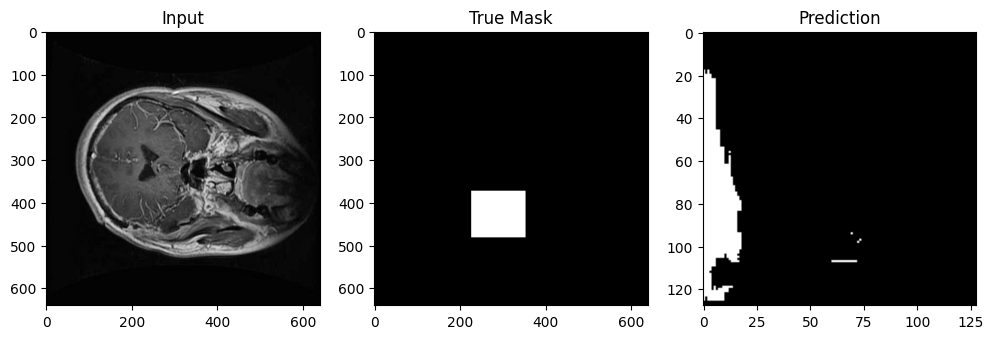

In [17]:
def predict(image_path, model):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    prediction = (prediction > 0.5).astype(np.uint8)

    return prediction[0]

def test_random_images(n=5):
    indices = np.random.randint(0, len(test_annotation['images']), size=n)
    images = [test_annotation['images'][i] for i in indices]
    annotations = [test_annotation['annotations'][i] for i in indices]

    plt.figure(figsize=(12, 4 * 2 * n))
    for img, ann in zip(images, annotations):
        plt.subplot(n, 3, 1)
        image = cv2.imread(os.path.join(test_path, img['file_name']))
        plt.imshow(image)
        plt.title("Input")

        mask = predict(os.path.join(test_path, img['file_name']), unet_model)
        result_image = np.zeros((128, 128, 1), dtype=np.uint8)
        result_image[mask == 1] = 255

        true_mask = cv2.imread(os.path.join('/content/test_masks/', img['file_name']))
        plt.subplot(n, 3, 2)
        plt.imshow(true_mask)
        plt.title("True Mask")

        plt.subplot(n, 3, 3)
        plt.imshow(result_image, cmap='gray')
        plt.title("Prediction")

test_random_images()
